In [4]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import log
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

print("Current working directory:", os.getcwd())

Current working directory: z:\Codes\TFG


# Análisis de LCEs vs $\sigma$

## Para un $x_0$ dado.
Hacemos un barrido de intensidades de ruido para el $x_0$ utilzado hasta ahora

In [3]:
# PRUEBA DE TIEMPO DE UN WOLF
from src.stoc_system import StochasticSystem

model = StochasticSystem(r, a, x0, total_time = 5000, dt = 5000/1e5, sigma =[0.04, 0.04, 0.04, 0.04])
t, x = model.euler_maruyama()
lces = model.estimate_LCE1_Wolf(
            x, evol_time=500,
            min_separation=180,
            max_replacements=500,
            start_indices= list([int(1e5 //4 ), int(1e5 // 2), int(1e5 // (4/3) )])
        )
print(lces[0])

0.14898070482682668


In [ ]:
def barrido_LCEs(total_time=5000, N_points=1e5, max_iters=50, save=False, save_path=None, save_name=None):
    """Función que realiza un barrido de diferentes intensidades de ruido del sistema y devuelve un array de NumPy con los resultados.
    :param total_time: Tiempo total de simulación
    :param N_points: Número de puntos para el método de Euler–Maruyama (se convertirá a entero)
    :param max_iters: Número máximo de iteraciones para el barrido (se convertirá a entero)
    :param save: Si True, guarda los resultados en un archivo CSV
    :param save_path: Ruta donde se guardará el archivo CSV
    :param save_name: Nombre del archivo CSV (sin extensión)
    :return: NumPy array de forma (max_iters, 3) con columnas [sigma, mean, std]
    """
    import numpy as np
    import os

    # aseguramos tipos enteros donde corresponda
    N_points = int(N_points)
    max_iters = int(max_iters)
    np.random.seed(2)

    # parámetros del sistema
    r = np.array([1, 0.72, 1.53, 1.27])
    a = np.array([
        [1, 1.09, 1.52, 0],
        [0, 1, 0.44, 1.36],
        [2.33, 0, 1, 0.47],
        [1.21, 0.51, 0.35, 1]
    ])
    x0 = np.array([0.5, 0.5, 0.5, 0.5])

    # valores de sigma a barrer
    array_sigmas = np.linspace(start=0.0, stop=1.5, num=max_iters)
    start_indices = [int(N_points * f) for f in (0.25, 0.5, 0.75)]

    # creamos un array para guardar los resultados
    resultados = np.zeros((max_iters, 3), dtype=float)

    for idx, sigma in enumerate(array_sigmas):
        print(f"{idx+1}/{max_iters}  sigma={sigma:.3f}...", end='\r')

        # creamos el sistema estocástico con un ruido asimétrico
        vect_ruido = sigma * np.array([0.8, 0.9, 1.0, 1.1])
        model = StochasticSystem(
            r, a, x0,
            total_time=total_time,
            dt=total_time / N_points,
            sigma=vect_ruido
        )

        # lo resolvemos 
        _, X = model.euler_maruyama()

        # hallamos su LCE
        _, vect_lambdas = model.estimate_LCE1_Wolf(
            X, evol_time=500,
            min_separation=180,
            max_replacements=500,
            start_indices=start_indices
        )

        # hallamos su media y std
        mean_val = np.nanmean(vect_lambdas)
        std_val = np.nanstd(vect_lambdas, ddof=1)

        resultados[idx, 0] = sigma
        resultados[idx, 1] = mean_val
        resultados[idx, 2] = std_val

    # guardado opcional en CSV
    if save and save_path and save_name:
        os.makedirs(save_path, exist_ok=True)
        filepath = os.path.join(save_path, f"{save_name}.csv")
        header = 'sigma,mean,std'
        np.savetxt(filepath, resultados, delimiter=',', header=header, comments='')

    return resultados

In [20]:
# prueba
barrido_test = barrido_LCEs(
    total_time=5000,
    N_points=1e5,
    max_iters=500
)


C:\Users\kikek\AppData\Local\Temp\ipykernel_98488\2781817706.py:60: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(vect_lambdas)


In [21]:
print(barrido_test.shape)

(500, 3)


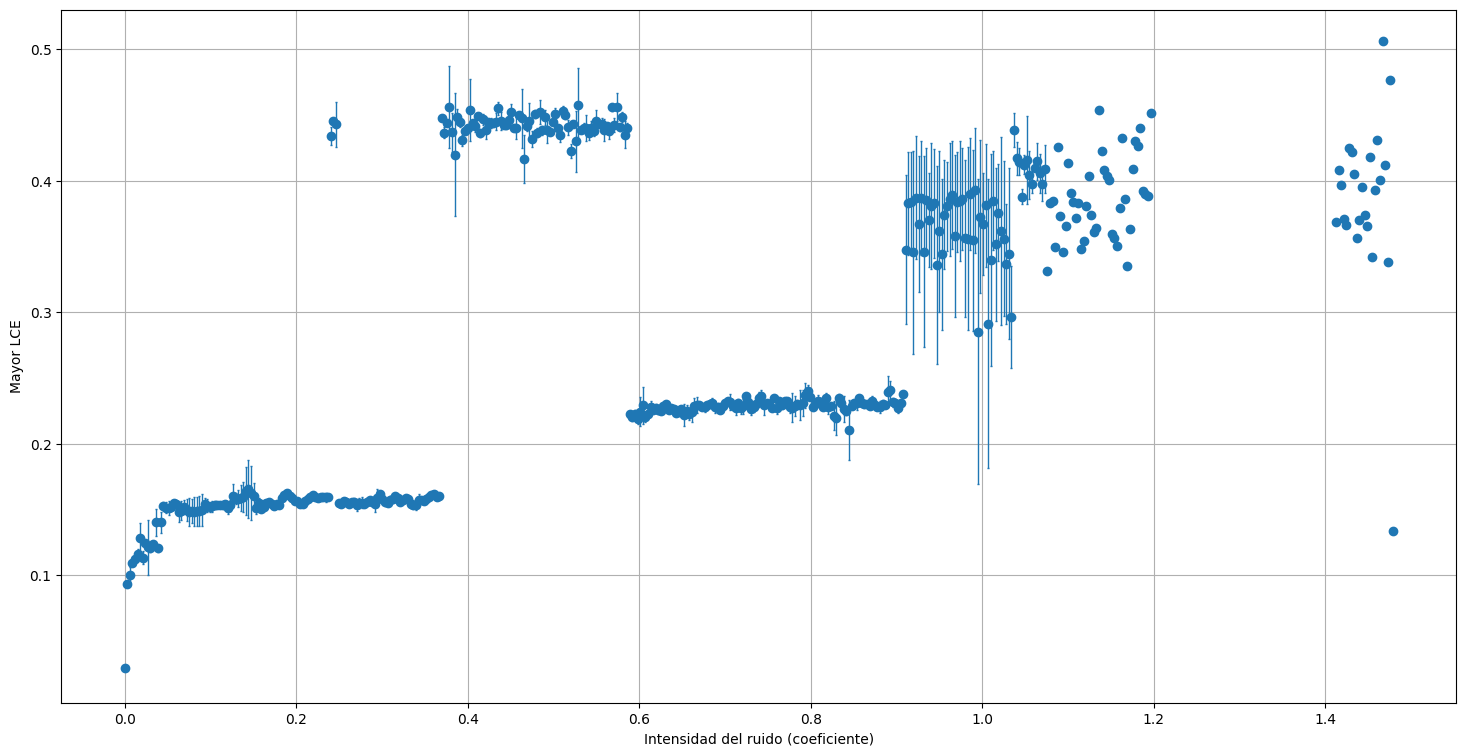

In [22]:
# creamos una gráfica para verlo
fig_barridos, ax_barridos = plt.subplots(figsize = (18,9))
plt.errorbar(
    x = barrido_test[:, 0], y = barrido_test[:, 1], yerr = barrido_test[:, 2], fmt = 'o', elinewidth = 1, capsize = 1 
)

plt.xlabel('Intensidad del ruido (coeficiente)')
plt.ylabel('Mayor LCE')                                                                           
plt.grid()
plt.show()

## Para un $x_0$ distinto en cada iteración
Ahora pruebo con el $x_0$ random en cada iteración

In [6]:
from src.functions import barrido_LCEs_random
barr_random = barrido_LCEs_random(
    total_time=5000,
    N_points=1e5,
    max_iters=5000
)

z:\Codes\TFG\src\stoc_system.py:156: RuntimeWarning: divide by zero encountered in log
  log_sum += np.log(dist_final / dist_init)
c:\Users\kikek\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


In [8]:
# guardamos los resultados porque son pesados
np.save('data/barrido_LCEs_random.npy', barr_random)

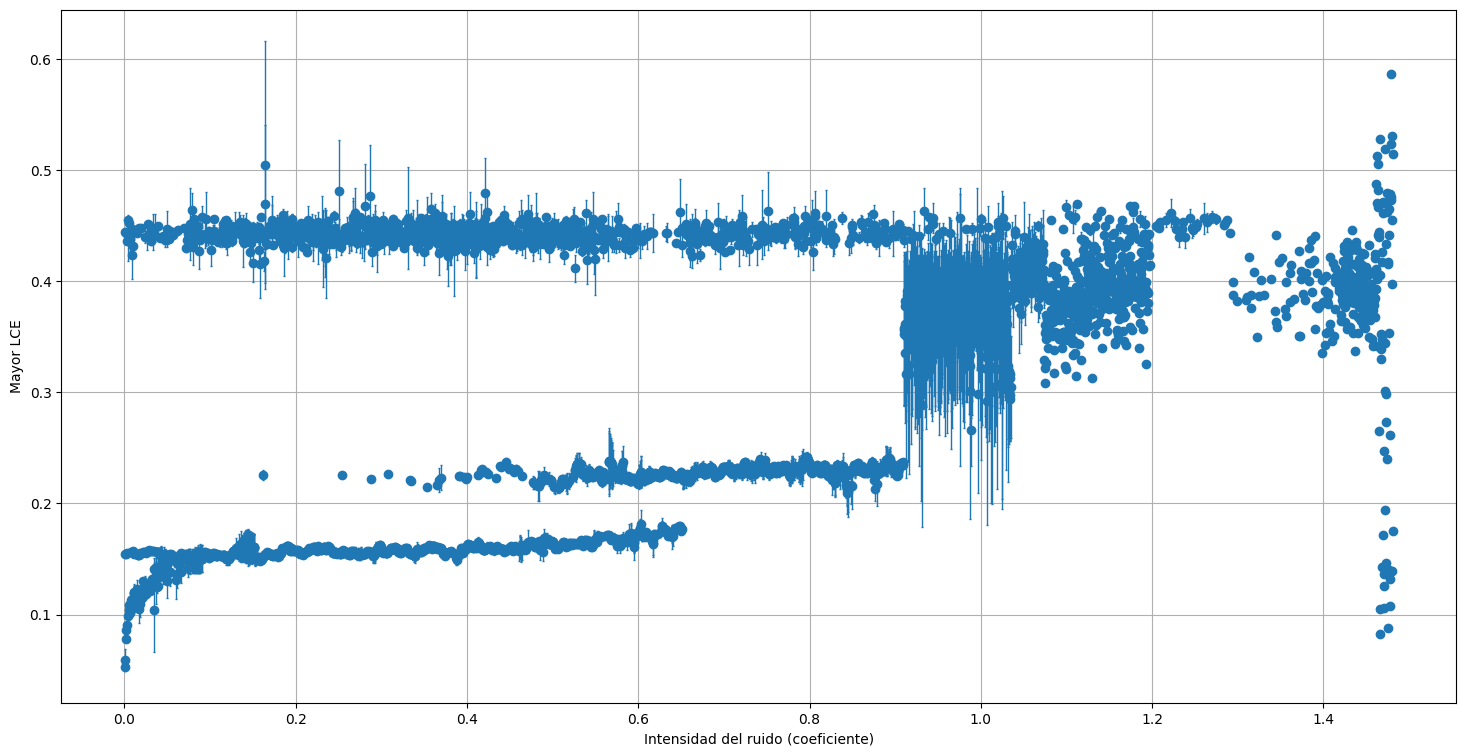

In [9]:
# creamos una gráfica para verlo
fig_barridos, ax_barridos = plt.subplots(figsize = (18,9))
plt.errorbar(
    x = barr_random[:, 0], y = barr_random[:, 1], yerr = barr_random[:, 2], fmt = 'o', elinewidth = 1, capsize = 1 
)

plt.xlabel('Intensidad del ruido (coeficiente)')
plt.ylabel('Mayor LCE')                                                                           
plt.grid()
plt.show()

## Diagrama de bifurcaciones

<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\l'
C:\Users\kikek\AppData\Local\Temp\ipykernel_114464\1463847563.py:43: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('$\sigma$', fontsize=16, weight='semibold')
C:\Users\kikek\AppData\Local\Temp\ipykernel_114464\1463847563.py:44: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\lambda_1$', fontsize=16, weight='semibold')


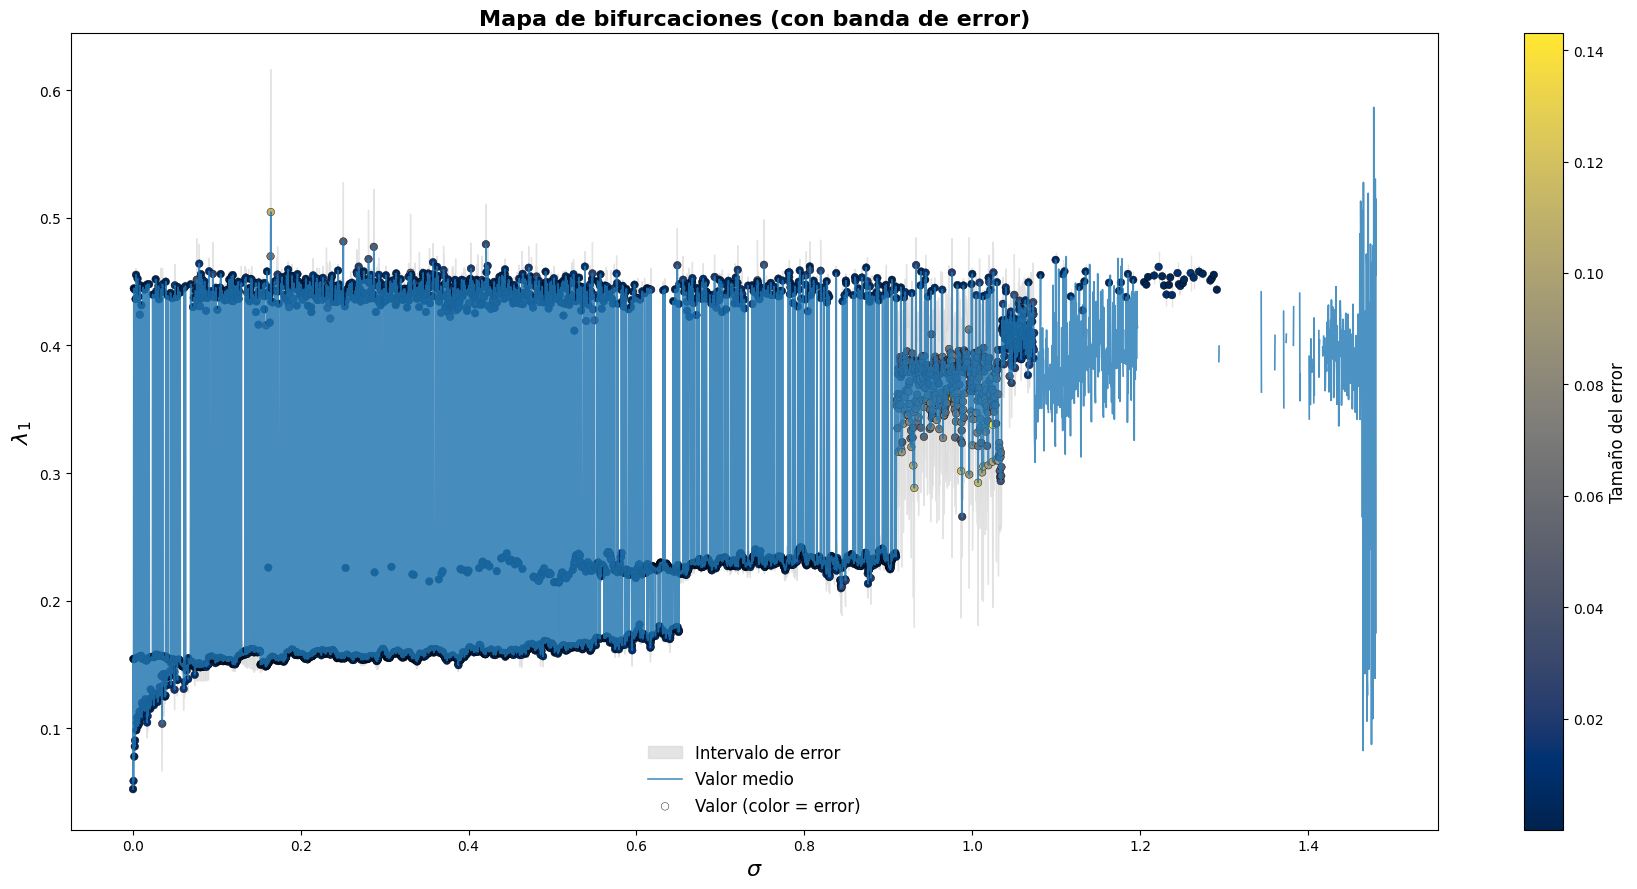

In [14]:

r   = barr_random[:, 0]
x   = barr_random[:, 1]
err = barr_random[:, 2]

fig, ax = plt.subplots(figsize=(18,9))

# 1) Banda sombreada de incertidumbre
ax.fill_between(
    r,
    x - err,
    x + err,
    color='lightgray',
    alpha=0.6,
    label='Intervalo de error'
)

# 2) Línea conectando los valores centrales
ax.plot(
    r,
    x,
    '-',
    linewidth=1.2,
    alpha=0.8,
    label='Valor medio'
)

# 3) Scatter coloreado según magnitud del error
sc = ax.scatter(
    r,
    x,
    c=err,
    cmap='cividis',
    s=30,
    edgecolor='k',
    linewidth=0.3,
    label='Valor (color = error)'
)
cbar = fig.colorbar(sc, ax=ax)
cbar.ax.set_ylabel('Tamaño del error', fontsize=12)

# 4) Estética
ax.set_title('Mapa de bifurcaciones (con banda de error)', fontsize=16, weight='bold')
ax.set_xlabel('$\sigma$', fontsize=16, weight='semibold')
ax.set_ylabel('$\lambda_1$', fontsize=16, weight='semibold')
ax.grid(False)
ax.legend(frameon=False, fontsize=12)

fig.tight_layout()
plt.show()

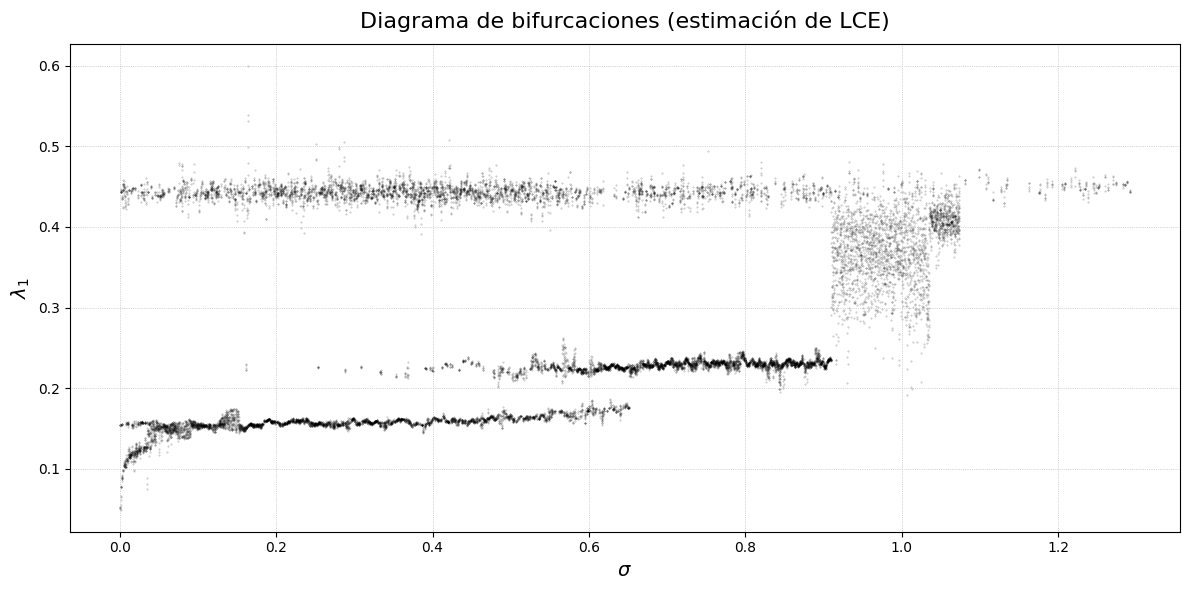

In [16]:

# extraemos parámetros
σ = barr_random[:, 0]
λ = barr_random[:, 1]
Δ = barr_random[:, 2]

# simulamos dispersión dentro del error para dar densidad
n_rep = 5  # cuántos puntos extra por valor de σ
σ_rep = np.repeat(σ, n_rep)
# distribuimos uniformemente en [λ-Δ, λ+Δ]
λ_jitter = np.repeat(λ, n_rep) + (np.random.rand(len(σ_rep)) * 2 - 1) * np.repeat(Δ, n_rep)

fig, ax = plt.subplots(figsize=(12, 6))

# scatter estilo bifurcación: muchos puntos chiquititos y algo transparentes
ax.scatter(
    σ_rep, λ_jitter,
    s=0.5,                    # tamaño de punto muy pequeño
    alpha=0.3,                # transparencia para ver densidades
    marker='.',               # marcador puntiagudo
    color='black'             # clásico negro
)

ax.set_title('Diagrama de bifurcaciones (estimación de LCE)', fontsize=16, pad=12)
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel(r'$\lambda_1$', fontsize=14)

# cuadrícula muy suave (opcional)
ax.grid(True, linestyle=':', linewidth=0.5)

fig.tight_layout()
plt.show()